In [1]:
import scanpy as sc
import mudata as md
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import scrublet as scr

In [2]:
path_nSBM = '../data/mudata_nSBM_hierarchy_2.h5mu'
data_nSBM = md.read_h5mu(path_nSBM)
data_nSBM

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\anndata\_core\anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\anndata\_core\anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\anndata\_core\anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


MuData object with n_obs × n_vars = 437964 × 32110
  3 modalities
    SC_genes:	437964 x 13536
      obs:	'strains'
      var:	'strains', 'matchin_protein', 'protein'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
    SC_proteins:	437964 x 13090
      obs:	'strains'
      var:	'genes_mapping', 'strains'
      uns:	'Consensus_tree', 'protein_adjacency_matrix', 'protein_match', 'protein_unmatch'
      varm:	'protein_hierarchy'
    SC_PCs:	437964 x 5484
      obs:	'strains'
      var:	'PCs_match'
      uns:	'Consensus_tree_PCs', 'PCs', 'PCs_to_genes', 'PCs_unmatch', 'Purity_info', 'Purity_info_unique', 'protein_match'
      varm:	'protein_hierarchy_PCs'

In [3]:
data_gex = data_nSBM['SC_genes'].copy()
data_gex

AnnData object with n_obs × n_vars = 437964 × 13536
    obs: 'strains'
    var: 'strains', 'matchin_protein', 'protein'
    uns: 'genes_match', 'protein_match', 'unmatch_genes'

In [4]:
data_gex_ec = data_gex[data_gex.obs['strains'] == 'GSM5456503_Ec_CDS'].copy()
data_gex_ec

AnnData object with n_obs × n_vars = 9654 × 13536
    obs: 'strains'
    var: 'strains', 'matchin_protein', 'protein'
    uns: 'genes_match', 'protein_match', 'unmatch_genes'

In [5]:
print(data_gex_ec.shape)
sc.pp.filter_genes(data_gex_ec, min_cells=1)
print(data_gex_ec.shape)

(9654, 13536)
(9654, 3642)


## Follow tutorial:
https://github.com/swolock/scrublet/blob/master/examples/scrublet_basics.ipynb

In [14]:
#Tried different exp doublet rates. not meaningful difference
scrub = scr.Scrublet(data_gex_ec.X.A, expected_doublet_rate=0.06)

In [15]:
doublet_scores, predicted_doublets = scrub.scrub_doublets(min_counts=2, 
                                                          min_cells=3, 
                                                          min_gene_variability_pctl=85, 
                                                          n_prin_comps=30)

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.06
Detected doublet rate = 20.1%
Estimated detectable doublet fraction = 30.5%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 65.7%
Elapsed time: 3.2 seconds


(<Figure size 800x300 with 2 Axes>,
 array([<Axes: title={'center': 'Observed transcriptomes'}, xlabel='Doublet score', ylabel='Prob. density'>,
        <Axes: title={'center': 'Simulated doublets'}, xlabel='Doublet score', ylabel='Prob. density'>],
       dtype=object))

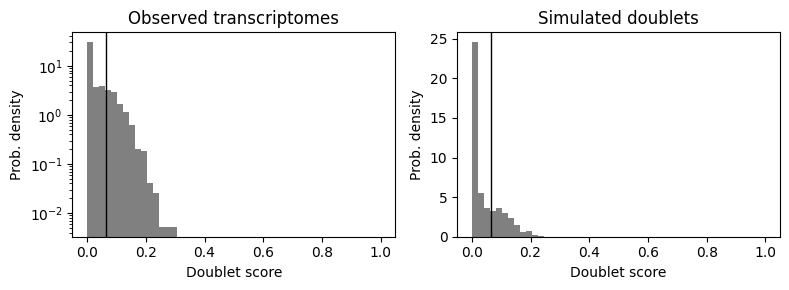

In [16]:
scrub.plot_histogram()

In [17]:
scrub.set_embedding('UMAP', scr.get_umap(scrub.manifold_obs_, 10, min_dist=0.3))

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(<Figure size 800x400 with 3 Axes>,
 array([<Axes: title={'center': 'Predicted doublets'}, xlabel='UMAP 1', ylabel='UMAP 2'>,
        <Axes: title={'center': 'Doublet score'}, xlabel='UMAP 1', ylabel='UMAP 2'>],
       dtype=object))

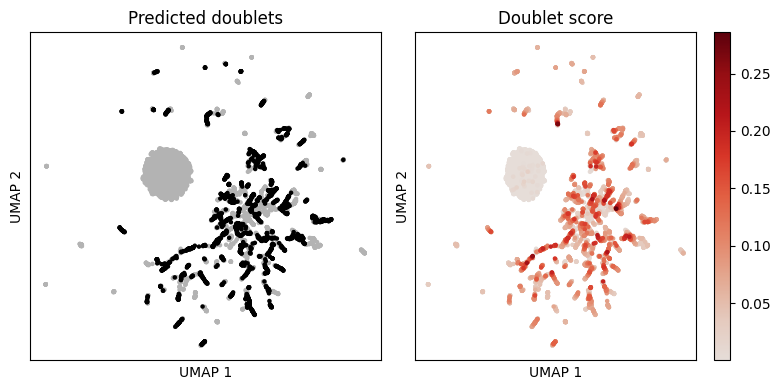

In [18]:
scrub.plot_embedding('UMAP', order_points=True)

In [19]:
data_gex_ec[np.where(predicted_doublets==True)]

View of AnnData object with n_obs × n_vars = 1937 × 3642
    obs: 'strains'
    var: 'strains', 'matchin_protein', 'protein', 'n_cells'
    uns: 'genes_match', 'protein_match', 'unmatch_genes'

looking at the sum of the counts we see that the cell with the highest count in the original matrix is not detected by scrublet

In [12]:
data_gex_ec[np.where(predicted_doublets==True)].X.A.sum(axis=1).max()

49.0

In [13]:
data_gex_ec.X.A.sum(axis=1).max()

816.0